In [203]:
import glob
import os
import csv
import numpy as np
from scipy.signal import medfilt
from scipy.signal import wiener
from scipy.signal import savgol_filter

genders = ['male', 'female']
labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral'] # 0-6, 7 classes

def preprocess_data(dataPath, train):
    if train:
        path = os.path.join(dataPath, 'train')
        output_dir = os.path.join(dataPath, 'train.csv')
    else:
        path = os.path.join(dataPath, 'val')
        output_dir = os.path.join(dataPath, 'val.csv')
    folders = glob.glob(os.path.join(path, '*'))
    folders.sort()

    with open(output_dir, 'a+') as csv_output_file:
        fieldnames = ['User', 'Person_min', 'Max', 'Min', 'Mean', 'Var', 'Mean Abs Diff', 'Mean Abs Second Diff', 'Emotion', 'Gender', 'Age'] # The features extracted
        writer = csv.DictWriter(csv_output_file, fieldnames=fieldnames)
        writer.writeheader()

        for dir in folders:
            with open(os.path.join(dir, 'EDA.csv')) as csv_file:
                csv_reader = csv.reader(csv_file)
                line_count = 0
                data = [] # all data for one person
                time_stamp = [] # time stamp for each item

                for row in csv_reader:
                    if line_count == 0:
                        start_time = float(row[0])
                    elif line_count == 1:
                        freq = float(row[0])
                    elif line_count>2 :
                        data.append(float(row[0]))
                        time_stamp.append(start_time + float((line_count-2)/freq))
                    line_count += 1

                #person_Max = max(data)
                #person_Min = min(data)
                data = (data - np.average(data)) / (np.std(data)) # standartization filter
                #data = (np.array(data) - float(person_Min)) / (float(person_Max) - float(person_Min)) # normalised data for each person
                #data = medfilt(data, 11) # median filter; can be substituted by your preprocessing methods
                #data = wiener(data)
                #data = savgol_filter(data, 11, 5)
                person_Max = max(data)
                person_Min = min(data)
                
            
                log = open(os.path.join(dir, 'log.txt'), 'r')
                log_count = 0
                for line in log:
                    if log_count == 0:
                        user = line.split(';')[0].split(':')[-1]
                        age = line.split(';')[1].split(':')[-1]
                        gender = line.split(';')[2].split(':')[-1]
                        gender = genders.index(gender.lower())
                        log_count += 1
                    elif log_count == 1:
                        log_count += 1
                    else:
                        st = float(line.split(';')[1]) # start time of each video
                        et = float(line.split(';')[3]) # end time of each video
                        video_name = line.split(';')[2]
                        if "_" in video_name:
                            emotion_label = line.split(';')[2].split('.')[0][:-10] # emotion label of each video
                        else:
                            emotion_label = line.split(';')[2].split('.')[0][:-9]  # emotion label of each video
                        emotion_label = labels.index(emotion_label)

                        index = np.where(np.logical_and((np.array(time_stamp) >= st), (np.array(time_stamp) <= et)))
                        data_list = data[index[0]]
                        if len(data_list)== 0:
                            break
                        diff_list = [data_list[k+1]-data_list[k] for k in range(len(data_list)-1)]
                        abs_diff_list = abs(np.array(diff_list))
                        second_diff_list = [diff_list[k + 1] - diff_list[k] for k in range(len(diff_list) - 1)]
                        abs_second_diff_list = abs(np.array(second_diff_list))
                        writer.writerow({'User': user, 'Person_min': person_Min,  'Max': max(data_list), 'Min': min(data_list), 'Mean': np.mean(data_list), 'Var': np.var(data_list), 'Mean Abs Diff': np.mean(abs_diff_list), 'Mean Abs Second Diff': np.mean(abs_second_diff_list),'Emotion': emotion_label, 'Gender': gender, 'Age': age})
                log.close()
        csv_file.close()
    csv_output_file.close()

In [204]:
# Preprocessing and reading dat
import pandas as pd
from sklearn.utils import shuffle


os.remove('train.csv')
preprocess_data('', train=1)
os.remove('val.csv')
preprocess_data('', train=0)


Data_train = pd.read_csv("train.csv", sep = ",")
Data_train = shuffle(Data_train)
#Data_train[Data_train.User == "Person_25"].head(10)
#Data_train.head(20)

Data_val = pd.read_csv("val.csv")
Data_val = shuffle(Data_val)
#Data_val[Data_val.User == "Person_25"].head(10)

# Vizualisation

In [205]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns


# plt.figure(figsize=(16, 10))
# plt.plot(np.arange(0, 1000, 1), Data_train.Mean.iloc[:1000], scaley = 100)
# plt.title("Mean variations")
# plt.legend(["y = mean common variation"])

# plt.show()

In [206]:
# #Max	Min	Mean	Var	Mean Abs Diff	Mean Abs Second Diff	Emotion

# sns.set(rc = {'figure.figsize':(16, 10)})
# sns.set_theme(style="darkgrid")
# sns.scatterplot(data = Data_train, x = "Mean", y = Data_train.index, hue = "Emotion", palette = "tab10", x_bins= 150)
# #sns.lineplot(data = Data_train.iloc[:1500], x = Data_train.Mean.iloc[:1500], y = np.arange(0, 1500, 1), hue = "Emotion", palette = "tab10")

In [207]:
#Data_train.isna().sum()

In [208]:
#Data_train.Emotion.value_counts()

In [209]:
Data_train[Data_train.User == "Person_25"].head(15)

,User,Person_min,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
1038,Person_25,-3.161054,1.033149,0.823431,0.950573,0.002252,0.054121,0.097869,5,0,23
1017,Person_25,-3.161054,0.487914,0.320140,0.398556,0.001729,0.053383,0.081890,1,0,23
1055,Person_25,-3.161054,1.788103,1.117037,1.217700,0.015339,0.103109,0.204242,4,0,23
1013,Person_25,-3.161054,0.362083,0.194309,0.306158,0.002150,0.056324,0.098691,1,0,23
1019,Person_25,-3.161054,0.529858,0.362083,0.439979,0.001891,0.052430,0.088302,0,0,23
1029,Person_25,-3.161054,0.739544,0.613745,0.678141,0.001191,0.035713,0.061276,0,0,23
1015,Person_25,-3.161054,0.445971,0.194309,0.364180,0.004306,0.081680,0.123501,1,0,23
1012,Person_25,-3.161054,0.362083,0.152365,0.276642,0.002408,0.062916,0.104020,1,0,23
998,Person_25,-3.161054,-0.057353,-0.225095,-0.138676,0.001805,0.056343,0.101445,6,0,23
1033,Person_25,-3.161054,0.781487,0.655689,0.733953,0.001376,0.038943,0.074203,0,0,23


In [210]:
Data_val[Data_val.User == "Person_25"].head(15)



,User,Person_min,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
685,Person_25,-3.161054,1.494497,0.697600,0.842232,0.017541,0.088379,0.167770,3,0,23
675,Person_25,-3.161054,-0.308983,-0.560645,-0.384804,0.002980,0.058721,0.096121,2,0,23
683,Person_25,-3.161054,0.865375,0.697600,0.817439,0.001723,0.052430,0.090510,3,0,23
687,Person_25,-3.161054,0.949262,0.781487,0.874493,0.002747,0.059102,0.087882,3,0,23
680,Person_25,-3.161054,0.865375,0.697600,0.783955,0.001753,0.039322,0.067110,3,0,23
672,Person_25,-3.161054,-0.350926,-0.476757,-0.409106,0.001893,0.055925,0.095458,2,0,23
677,Person_25,-3.161054,0.823431,0.655689,0.756704,0.001864,0.045935,0.079690,3,0,23
686,Person_25,-3.161054,0.907318,0.739544,0.853038,0.002849,0.068158,0.123035,3,0,23
681,Person_25,-3.161054,0.907318,0.697600,0.813444,0.002497,0.060818,0.105963,3,0,23
682,Person_25,-3.161054,0.907318,0.739544,0.834870,0.001788,0.051930,0.096470,3,0,23


####  Data is distributed normally. No NaN values. Sad and happy emotions have more samples than others -> might have to equalize value counts

In [211]:
# Merging val and train data
print(Data_train.shape, Data_val.shape)
Data_train = pd.merge(Data_train, Data_val, how = 'outer')
Data_train.shape

(3554, 11) (1737, 11)


(5291, 11)

### Valence prediction

In [212]:
#Positive: surprise, happy, neutral
#Negative: else
# labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral'] # 0-6, 7 classes

def getValence(row) -> int:
        if row['Emotion'] == 0 or row['Emotion'] == 1 or row['Emotion'] == 6:
            return 1
        else:
            return 0

Data_train['Valence'] = Data_train.apply(lambda row: getValence(row), axis = 1)

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

y = Data_train.Emotion
z = Data_train.Valence
X = pd.DataFrame(Data_train.drop(['Emotion','User', 'Valence'], axis = 1))

models = [ KNeighborsClassifier(n_neighbors= 7), DecisionTreeClassifier(), RandomForestClassifier()]
model_names = ['K-Neighbors Classifier', 'Decision Tree Classifier', 'Random Forest Classifier']
scores = np.zeros([len(models), 1])

#X_train = pd.concat([X_train, pd.DataFrame(clf.predict(X_train), columns = ['Valence'])], axis = 1)
    #X_test = pd.concat([X_test, pd.DataFrame(clf.predict(X_test), columns = ['Valence'])], axis = 1)
    #clf = m.fit(X_train, y_train)
#for i, m in enumerate(models):
#    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size = 0.3, random_state = 123)
#    clf =  m.fit(X_train, z_train)
#    scores[i] = clf.score(X_test, y_test)
#    print(clf.predict(X_train))

#scores = pd.DataFrame(scores, columns=['score'], index=model_names)
#scores

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.3, random_state = 123)

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, z_train)

z_pred = clf.predict(X)
X = pd.concat([X, pd.DataFrame(data = z_pred, columns = ['Valence'])], axis = 1)
print("Valence acc score: ", clf.score(X_test, z_test))

for i, m in enumerate(models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    clf =  m.fit(X_train, y_train)
    scores[i] = clf.score(X_test, y_test)
    
scores = pd.DataFrame(scores, columns=['score'], index=model_names)
scores


# K-Neighbors Classifier	0.584383
# Decision Tree Classifier	0.493703
# Random Forest Classifier	0.568010

Valence acc score:  0.7726700251889169


,score
K-Neighbors Classifier,0.571159
Decision Tree Classifier,0.484887
Random Forest Classifier,0.557935


## Modeling

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.regularizers import L1, L2, L1L2

def initModelBasic(shape, outputUnits) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    model = Sequential()
    
    model.add(tf.keras.Input(shape = (shape)))
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(outputUnits, activation = 'softmax'))
    print(model.summary())
    return model

def initModelValence(shape, outputUnits) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    model = Sequential()
    
    model.add(tf.keras.Input(shape = shape))
    
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    #model.add(ReLU())
    
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    #model.add(ReLU())
    
    model.add(Dense(outputUnits, activation = 'sigmoid'))
    print(model.summary())
    return model

    

In [121]:
#Get target variables: emotion and valence
z = Data_train.Valence
y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion','User', 'Valence'], axis = 1))

#find valence
tf.random.set_seed(123)

modelValence = initModelValence(X.shape[1], 1)
modelValence.compile(
    optimizer= 'adam',
    loss='binary_crossentropy', 
    metrics=[ 'binary_accuracy']
)

historyValence = modelValence.fit(
    X,
    z,
    validation_split = 0.3,
    #validation_data = (X_val, y_val),
    #validation_data = (X_test, y_test),
    epochs=600,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_binary_accuracy',
            patience=150,
            restore_best_weights=True
        )
    ]
)

model_acc = modelValence.evaluate(X, z, verbose=0)[1]
print("Accuracy of the valence model: {:.3f}%".format(model_acc * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,137
Trainable params: 2,945
Non-trainabl

116/116 [==============================] - 0s 3ms/step - loss: 0.6565 - binary_accuracy: 0.5971 - val_loss: 0.7299 - val_binary_accuracy: 0.4723
Epoch 46/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6559 - binary_accuracy: 0.6014 - val_loss: 0.7701 - val_binary_accuracy: 0.4559
Epoch 47/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6573 - binary_accuracy: 0.6030 - val_loss: 0.8169 - val_binary_accuracy: 0.4773
Epoch 48/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6557 - binary_accuracy: 0.6033 - val_loss: 0.7820 - val_binary_accuracy: 0.4427
Epoch 49/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6580 - binary_accuracy: 0.6073 - val_loss: 0.7073 - val_binary_accuracy: 0.5031
Epoch 50/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6560 - binary_accuracy: 0.5998 - val_loss: 0.7357 - val_binary_accuracy: 0.5000
Epoch 51/600
116/116 [==============================] - 0s 3ms/st

Epoch 97/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6291 - binary_accuracy: 0.6408 - val_loss: 0.8089 - val_binary_accuracy: 0.4679
Epoch 98/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6316 - binary_accuracy: 0.6403 - val_loss: 0.7767 - val_binary_accuracy: 0.5013
Epoch 99/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6337 - binary_accuracy: 0.6379 - val_loss: 0.7968 - val_binary_accuracy: 0.4377
Epoch 100/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6351 - binary_accuracy: 0.6379 - val_loss: 0.7541 - val_binary_accuracy: 0.4912
Epoch 101/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6312 - binary_accuracy: 0.6352 - val_loss: 0.7419 - val_binary_accuracy: 0.5258
Epoch 102/600
116/116 [==============================] - 0s 3ms/step - loss: 0.6334 - binary_accuracy: 0.6352 - val_loss: 0.7396 - val_binary_accuracy: 0.5076
Epoch 103/600
116/116 [==========================

116/116 [==============================] - 0s 3ms/step - loss: 0.6213 - binary_accuracy: 0.6530 - val_loss: 0.7806 - val_binary_accuracy: 0.4956
Epoch 149/600
 55/116 [=============>................] - ETA: 0s - loss: 0.6206 - binary_accuracy: 0.6597

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split

#Get target variables: emotion and valence
z = Data_train.Valence
y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion','User', 'Valence'], axis = 1))

#find valence
tf.random.set_seed(123)

modelValence = initModelValence(X.shape[1], 2)
modelValence.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', 
    metrics=[ 'sparse_categorical_accuracy']
)

historyValence = modelValence.fit(
    X,
    z,
    validation_split = 0.3,
    #validation_data = (X_val, y_val),
    #validation_data = (X_test, y_test),
    epochs=600,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=75,
            restore_best_weights=True
        )
    ]
)

model_acc = modelValence.evaluate(X, z, verbose=0)[1]
print("Accuracy of the valence model: {:.3f}%".format(model_acc * 100))

Data_valence = modelValence.predict(X)
Data_valence = [(np.argmax(pre)) for pre in Data_valence]
#print(Data_valence, z)

X = pd.concat([X, pd.DataFrame(Data_valence, columns = ['Valence'])], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)



model = initModelBasic(X.shape[1], 7)
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', # sparse because using integer labels for emotions (not OHE)
    metrics=[ 'sparse_categorical_accuracy']
)

history = model.fit(
    X_train,
    y_train,
    #validation_split = 0.3,
    #validation_data = (X_val, y_val),
    validation_data = (X_test, y_test),
    epochs=600,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=75,
            restore_best_weights=True
        )
    ]
)

#Result on test data
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

#Result on val data
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

In [44]:
from sklearn.model_selection import train_test_split


np.random.seed = 123

y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion','User'], axis = 1))

#y_val = Data_val.Emotion
#X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)



model = initModelBasic(X.shape[1], 7)
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', # sparse because using integer labels for emotions (not OHE)
    metrics=[ 'sparse_categorical_accuracy']
)

history = model.fit(
    X_train,
    y_train,
    #validation_split = 0.3,
    #validation_data = (X_val, y_val),
    validation_data = (X_test, y_test),
    epochs=1200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=200,
            restore_best_weights=True
        )
    ]
)

#Result on test data
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

#Result on val data
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 16)                0

Epoch 38/1200
105/105 [==============================] - 0s 3ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.4079 - val_loss: 1.2105 - val_sparse_categorical_accuracy: 0.4150
Epoch 39/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1984 - sparse_categorical_accuracy: 0.4049 - val_loss: 1.2094 - val_sparse_categorical_accuracy: 0.4030
Epoch 40/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.2020 - sparse_categorical_accuracy: 0.4127 - val_loss: 1.2099 - val_sparse_categorical_accuracy: 0.4074
Epoch 41/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.2027 - sparse_categorical_accuracy: 0.4043 - val_loss: 1.2172 - val_sparse_categorical_accuracy: 0.4018
Epoch 42/1200
105/105 [==============================] - 0s 3ms/step - loss: 1.1981 - sparse_categorical_accuracy: 0.4064 - val_loss: 1.2068 - val_sparse_categorical_accuracy: 0.4125
Epoch 43/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1989 -

Epoch 83/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.4244 - val_loss: 1.1861 - val_sparse_categorical_accuracy: 0.4301
Epoch 84/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1702 - sparse_categorical_accuracy: 0.4343 - val_loss: 1.1959 - val_sparse_categorical_accuracy: 0.4263
Epoch 85/1200
105/105 [==============================] - 0s 3ms/step - loss: 1.1719 - sparse_categorical_accuracy: 0.4253 - val_loss: 1.2021 - val_sparse_categorical_accuracy: 0.4106
Epoch 86/1200
105/105 [==============================] - 0s 3ms/step - loss: 1.1692 - sparse_categorical_accuracy: 0.4343 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.4395
Epoch 87/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1728 - sparse_categorical_accuracy: 0.4337 - val_loss: 1.1787 - val_sparse_categorical_accuracy: 0.4181
Epoch 88/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1693 -

105/105 [==============================] - 0s 2ms/step - loss: 1.1512 - sparse_categorical_accuracy: 0.4493 - val_loss: 1.1540 - val_sparse_categorical_accuracy: 0.4490
Epoch 128/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1622 - sparse_categorical_accuracy: 0.4418 - val_loss: 1.1630 - val_sparse_categorical_accuracy: 0.4339
Epoch 129/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1575 - sparse_categorical_accuracy: 0.4442 - val_loss: 1.1630 - val_sparse_categorical_accuracy: 0.4207
Epoch 130/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.4397 - val_loss: 1.1781 - val_sparse_categorical_accuracy: 0.4181
Epoch 131/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1579 - sparse_categorical_accuracy: 0.4466 - val_loss: 1.1693 - val_sparse_categorical_accuracy: 0.4452
Epoch 132/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1520 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.1473 - sparse_categorical_accuracy: 0.4496 - val_loss: 1.1487 - val_sparse_categorical_accuracy: 0.4603
Epoch 172/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1393 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.1438 - val_sparse_categorical_accuracy: 0.4521
Epoch 173/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1388 - sparse_categorical_accuracy: 0.4562 - val_loss: 1.1742 - val_sparse_categorical_accuracy: 0.4270
Epoch 174/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1583 - sparse_categorical_accuracy: 0.4454 - val_loss: 1.1553 - val_sparse_categorical_accuracy: 0.4370
Epoch 175/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1427 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.1451 - val_sparse_categorical_accuracy: 0.4547
Epoch 176/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1504 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.1397 - sparse_categorical_accuracy: 0.4565 - val_loss: 1.1387 - val_sparse_categorical_accuracy: 0.4446
Epoch 216/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1358 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.1469 - val_sparse_categorical_accuracy: 0.4276
Epoch 217/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1327 - sparse_categorical_accuracy: 0.4565 - val_loss: 1.1413 - val_sparse_categorical_accuracy: 0.4660
Epoch 218/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1220 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.1430 - val_sparse_categorical_accuracy: 0.4565
Epoch 219/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1384 - sparse_categorical_accuracy: 0.4574 - val_loss: 1.1582 - val_sparse_categorical_accuracy: 0.4326
Epoch 220/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1393 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.1299 - sparse_categorical_accuracy: 0.4631 - val_loss: 1.1278 - val_sparse_categorical_accuracy: 0.4578
Epoch 260/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1252 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.1361 - val_sparse_categorical_accuracy: 0.4673
Epoch 261/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1242 - sparse_categorical_accuracy: 0.4748 - val_loss: 1.1742 - val_sparse_categorical_accuracy: 0.4402
Epoch 262/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1101 - sparse_categorical_accuracy: 0.4676 - val_loss: 1.1467 - val_sparse_categorical_accuracy: 0.4458
Epoch 263/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1184 - sparse_categorical_accuracy: 0.4700 - val_loss: 1.1371 - val_sparse_categorical_accuracy: 0.4597
Epoch 264/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1277 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.1217 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2150 - val_sparse_categorical_accuracy: 0.4169
Epoch 304/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1229 - sparse_categorical_accuracy: 0.4724 - val_loss: 1.1194 - val_sparse_categorical_accuracy: 0.4767
Epoch 305/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1209 - sparse_categorical_accuracy: 0.4631 - val_loss: 1.1338 - val_sparse_categorical_accuracy: 0.4591
Epoch 306/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1254 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.1637 - val_sparse_categorical_accuracy: 0.4547
Epoch 307/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1330 - sparse_categorical_accuracy: 0.4673 - val_loss: 1.1614 - val_sparse_categorical_accuracy: 0.4521
Epoch 308/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1390 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.1170 - sparse_categorical_accuracy: 0.4682 - val_loss: 1.1346 - val_sparse_categorical_accuracy: 0.4528
Epoch 348/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1134 - sparse_categorical_accuracy: 0.4682 - val_loss: 1.1386 - val_sparse_categorical_accuracy: 0.4559
Epoch 349/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1168 - sparse_categorical_accuracy: 0.4682 - val_loss: 1.1230 - val_sparse_categorical_accuracy: 0.4736
Epoch 350/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1117 - sparse_categorical_accuracy: 0.4781 - val_loss: 1.1717 - val_sparse_categorical_accuracy: 0.4270
Epoch 351/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1207 - sparse_categorical_accuracy: 0.4706 - val_loss: 1.1384 - val_sparse_categorical_accuracy: 0.4660
Epoch 352/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1200 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.1221 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.1099 - val_sparse_categorical_accuracy: 0.4710
Epoch 392/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1149 - sparse_categorical_accuracy: 0.4718 - val_loss: 1.1255 - val_sparse_categorical_accuracy: 0.4666
Epoch 393/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1116 - sparse_categorical_accuracy: 0.4697 - val_loss: 1.1168 - val_sparse_categorical_accuracy: 0.4773
Epoch 394/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1099 - sparse_categorical_accuracy: 0.4664 - val_loss: 1.1178 - val_sparse_categorical_accuracy: 0.4868
Epoch 395/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1165 - sparse_categorical_accuracy: 0.4691 - val_loss: 1.1236 - val_sparse_categorical_accuracy: 0.4698
Epoch 396/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1163 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.1117 - sparse_categorical_accuracy: 0.4778 - val_loss: 1.1164 - val_sparse_categorical_accuracy: 0.4628
Epoch 436/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1004 - sparse_categorical_accuracy: 0.4820 - val_loss: 1.1299 - val_sparse_categorical_accuracy: 0.4528
Epoch 437/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1111 - sparse_categorical_accuracy: 0.4793 - val_loss: 1.1313 - val_sparse_categorical_accuracy: 0.4673
Epoch 438/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1034 - sparse_categorical_accuracy: 0.4826 - val_loss: 1.1096 - val_sparse_categorical_accuracy: 0.4742
Epoch 439/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1143 - sparse_categorical_accuracy: 0.4763 - val_loss: 1.1364 - val_sparse_categorical_accuracy: 0.4641
Epoch 440/1200
105/105 [==============================] - 0s 3ms/step - loss: 1.1045 - sparse_c

105/105 [==============================] - 0s 2ms/step - loss: 1.0991 - sparse_categorical_accuracy: 0.4862 - val_loss: 1.1431 - val_sparse_categorical_accuracy: 0.4622
Epoch 480/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1097 - sparse_categorical_accuracy: 0.4754 - val_loss: 1.1255 - val_sparse_categorical_accuracy: 0.4654
Epoch 481/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.0976 - sparse_categorical_accuracy: 0.4808 - val_loss: 1.1166 - val_sparse_categorical_accuracy: 0.4729
Epoch 482/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1024 - sparse_categorical_accuracy: 0.4808 - val_loss: 1.1430 - val_sparse_categorical_accuracy: 0.4528
Epoch 483/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1021 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.1116 - val_sparse_categorical_accuracy: 0.4660
Epoch 484/1200
105/105 [==============================] - 0s 2ms/step - loss: 1.1061 - sparse_c

Accuracy of the model on test set: 48.992%


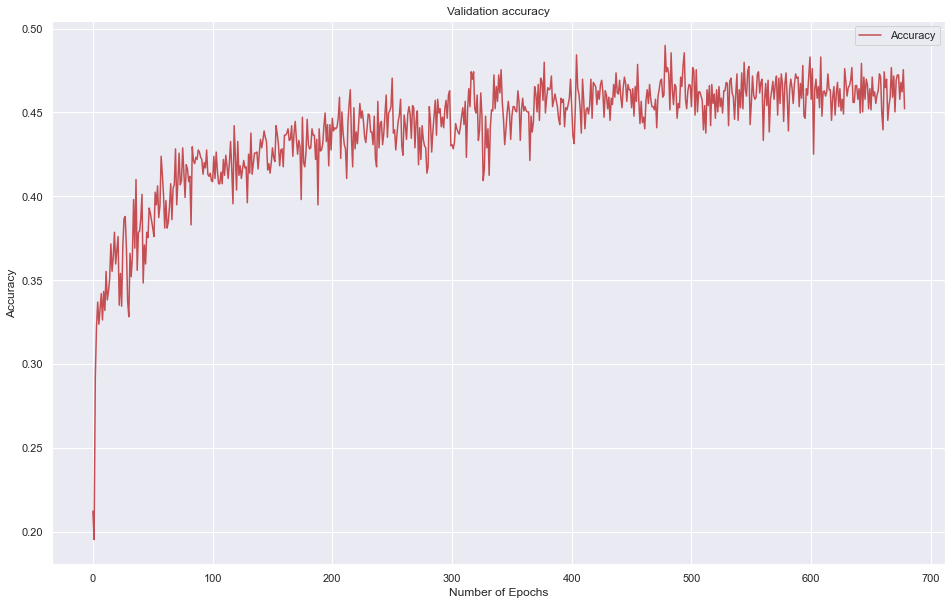

Accuracy of the model on validation set: 52.022%
2
[5, 0, 6, 5, 2, 1, 6, 0, 4, 1, 6, 6, 5, 6, 3, 5, 1, 4, 6, 5, 0, 0, 3, 0, 3, 3, 3, 5, 2, 6, 4, 0, 3, 1, 0, 5, 6, 1, 6, 5, 0, 4, 3, 1, 6, 5, 2, 5, 0, 6, 6, 3, 5, 6, 5, 3, 0, 6, 0, 4, 6, 3, 0, 3, 5, 0, 6, 6, 6, 6, 3, 6, 0, 3, 5, 4, 5, 0, 1, 6, 2, 5, 4, 0, 6, 5, 3, 0, 5, 6, 6, 0, 5, 5, 6, 3, 4, 0, 6, 0, 0, 5, 2, 0, 0, 4, 0, 1, 3, 2, 3, 1, 0, 5, 0, 4, 3, 5, 0, 2, 0, 3, 0, 5, 3, 5, 6, 6, 0, 1, 0, 1, 4, 6, 6, 5, 6, 2, 2, 1, 5, 5, 6, 2, 6, 4, 3, 3, 6, 0, 0, 2, 0, 0, 6, 3, 3, 3, 3, 3, 0, 5, 5, 0, 3, 6, 0, 5, 0, 5, 5, 0, 6, 3, 1, 5, 5, 4, 3, 0, 2, 3, 5, 0, 0, 2, 6, 4, 3, 2, 6, 6, 0, 6, 5, 1, 3, 6, 0, 5, 6, 2, 2, 6, 6, 5, 1, 6, 0, 4, 1, 2, 3, 5, 1, 0, 2, 5, 6, 4, 3, 3, 6, 2, 6, 5, 0, 3, 4, 6, 3, 6, 3, 5, 5, 3, 6, 5, 3, 5, 6, 6, 3, 2, 5, 6, 2, 0, 5, 5, 0, 0, 1, 3, 6, 2, 2, 5, 6, 4, 3, 0, 0, 4, 6, 0, 5, 4, 6, 1, 1, 3, 6, 0, 5, 5, 5, 0, 5, 1, 5, 1, 6, 4, 3, 2, 5, 0, 3, 0, 3, 5, 5, 5, 5, 2, 5, 3, 5, 0, 6, 6, 6, 3, 0, 6, 0, 5, 2, 0, 0, 6, 3, 0, 5, 2, 

In [33]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#model.save('8_features_train_test_16.983')
#test 60.691  val 16.983
#model = load_model('8_features_train_test') #val 19%!



model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))



# Plot the accuracy curve for training
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r', label="Accuracy")

plt.title("Validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

y_val_pred = model.predict(X_val)
y_val_pred = [np.argmax(pre) for pre in y_val_pred]
print(np.argmax(y_val_pred))
print(y_val_pred)

In [84]:
# # Training on validation data (Experimental)
# from sklearn.model_selection import train_test_split


# y_val = Data_val.Emotion
# X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))

# X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_val, y_val, test_size = 0.3, random_state = 123)


# #Trying adam optimizer
# modelVal = initModelGRU(X.shape[1], 7, 'softmax')
# modelVal.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# historyVal = modelVal.fit(
#     X_train_val,
#     y_train_val,
#     validation_data = (X_test_val, y_test_val),
#     epochs=1000,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100,
#             restore_best_weights=True
#         )
#     ]
# )

# #Result of adam optimizer on validation data
# model_acc = modelVal.evaluate(X_test_val, y_test_val, verbose=0)[1]
# print("Validation Accuracy: {:.3f}%".format(model_acc * 100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 9, 1)             0         
                                                                 
 gru (GRU)                   (None, 9, 256)            198912    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 7)                 16135     
                                                                 
Total params: 215,047
Trainable params: 215,047
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
38/38 [==============================

Epoch 107/1000
38/38 [==============================] - 1s 35ms/step - loss: 1.2008 - accuracy: 0.5053 - val_loss: 1.3129 - val_accuracy: 0.4866
Epoch 108/1000
38/38 [==============================] - 1s 37ms/step - loss: 1.1968 - accuracy: 0.5251 - val_loss: 1.2973 - val_accuracy: 0.4789
Epoch 109/1000
38/38 [==============================] - 2s 57ms/step - loss: 1.1777 - accuracy: 0.5136 - val_loss: 1.3076 - val_accuracy: 0.5077
Epoch 110/1000
38/38 [==============================] - 3s 90ms/step - loss: 1.1519 - accuracy: 0.5284 - val_loss: 1.3027 - val_accuracy: 0.5077
Epoch 111/1000
38/38 [==============================] - 4s 103ms/step - loss: 1.1545 - accuracy: 0.5333 - val_loss: 1.3478 - val_accuracy: 0.5096
Epoch 112/1000
38/38 [==============================] - 3s 92ms/step - loss: 1.1566 - accuracy: 0.5202 - val_loss: 1.3114 - val_accuracy: 0.4981
Epoch 113/1000
38/38 [==============================] - 3s 84ms/step - loss: 1.1667 - accuracy: 0.5284 - val_loss: 1.2720 - val_a

38/38 [==============================] - 1s 38ms/step - loss: 0.8975 - accuracy: 0.6255 - val_loss: 1.1933 - val_accuracy: 0.6054
Epoch 220/1000
38/38 [==============================] - 2s 47ms/step - loss: 0.8827 - accuracy: 0.6362 - val_loss: 1.2186 - val_accuracy: 0.5747
Epoch 221/1000
38/38 [==============================] - 4s 109ms/step - loss: 0.8770 - accuracy: 0.6370 - val_loss: 1.2194 - val_accuracy: 0.5690
Epoch 222/1000
38/38 [==============================] - 4s 108ms/step - loss: 0.8879 - accuracy: 0.6354 - val_loss: 1.2194 - val_accuracy: 0.5977
Epoch 223/1000
38/38 [==============================] - 5s 119ms/step - loss: 0.8923 - accuracy: 0.6387 - val_loss: 1.2297 - val_accuracy: 0.5728
Epoch 224/1000
38/38 [==============================] - 3s 79ms/step - loss: 0.8979 - accuracy: 0.6272 - val_loss: 1.2010 - val_accuracy: 0.5690
Epoch 225/1000
38/38 [==============================] - 1s 38ms/step - loss: 0.8750 - accuracy: 0.6263 - val_loss: 1.2033 - val_accuracy: 0.59

38/38 [==============================] - 2s 57ms/step - loss: 0.7569 - accuracy: 0.6741 - val_loss: 1.2542 - val_accuracy: 0.6456
Epoch 332/1000
38/38 [==============================] - 1s 34ms/step - loss: 0.7976 - accuracy: 0.6650 - val_loss: 1.2216 - val_accuracy: 0.6245
Epoch 333/1000
38/38 [==============================] - 1s 34ms/step - loss: 0.7627 - accuracy: 0.6642 - val_loss: 1.2549 - val_accuracy: 0.5977
Epoch 334/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.7383 - accuracy: 0.6724 - val_loss: 1.2573 - val_accuracy: 0.6226
Epoch 335/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.7911 - accuracy: 0.6560 - val_loss: 1.3300 - val_accuracy: 0.5728
Epoch 336/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.7552 - accuracy: 0.6683 - val_loss: 1.2894 - val_accuracy: 0.6111
Epoch 337/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.7837 - accuracy: 0.6708 - val_loss: 1.3041 - val_accuracy: 0.5958


In [13]:
# # Plot the accuracy curve for validation set
# import matplotlib.pyplot as plt
# plt.plot(historyVal.history['val_accuracy'], color='r', label="Accuracy")

# plt.title("Val accuracy")
# plt.xlabel("Number of Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

In [86]:
# predict = model.predict(X_test)[0]
# predict = [np.argmax(pre) for pre in predict]
# print(predict)
# y_test.head()